# Package import

In [171]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# chaining operations
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.preprocessing import StandardScaler

# training
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# performeance metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, precision_score, confusion_matrix, make_scorer, accuracy_score

# Data loading

In [2]:
df = pd.read_csv('./data/diabetes.csv')

# Data summary

## Descriptive information

Firsrt have a look at the shape of the data, and check that head and tail of file look similar.

In [4]:
df.shape

(768, 9)

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [9]:
target = 'Outcome'

In [10]:
stat_df = df.describe().T
stat_df = stat_df.reset_index().rename(columns={'index': 'column'})

In [116]:
stat_df['distinct_vals'] = stat_df['column'].apply(lambda x: len(df[x].value_counts()))
stat_df['target_corr'] = stat_df['column'].apply(lambda x: np.corrcoef(df[target], df[x], rowvar=False)[0][1])
stat_df['nb_NA'] = stat_df['column'].apply(lambda x: np.sum(df[x].isnull().any()))

In [117]:
stat_df

,column,count,mean,std,min,25%,50%,75%,max,distinct_vals,target_corr,nb_NA
0,Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00,17,0.221898,0
1,Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00,136,0.466581,0
2,BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00,47,0.065068,0
3,SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00,51,0.074752,0
4,Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00,186,0.130548,0
5,BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10,248,0.292695,0
6,DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42,517,0.173844,0
7,Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00,52,0.238356,0
8,Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00,2,1.000000,0


## Data visualization

### Univariate boxplots: feature vs outcome

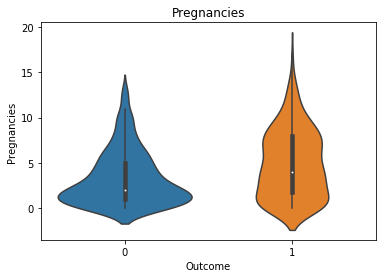

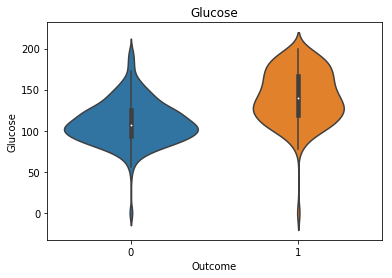

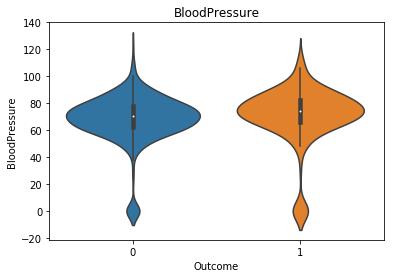

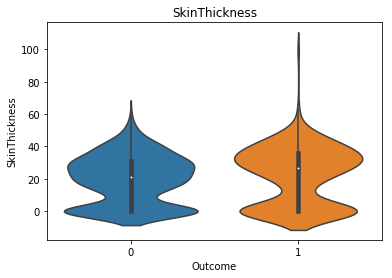

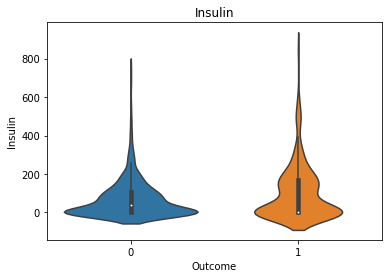

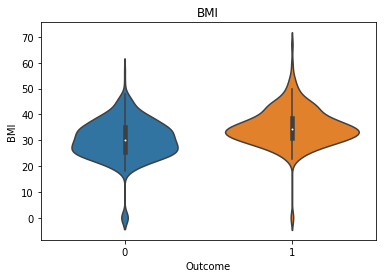

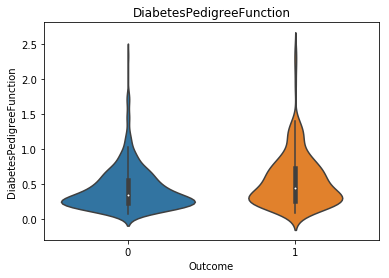

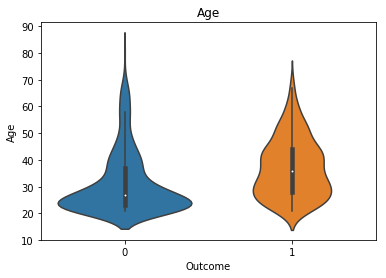

In [106]:
for col in df.columns:
    if (col != target):
        plt.figure()
        sns.violinplot(x=df[target], y=df[col])
        plt.title(col)

### Correlation matrix

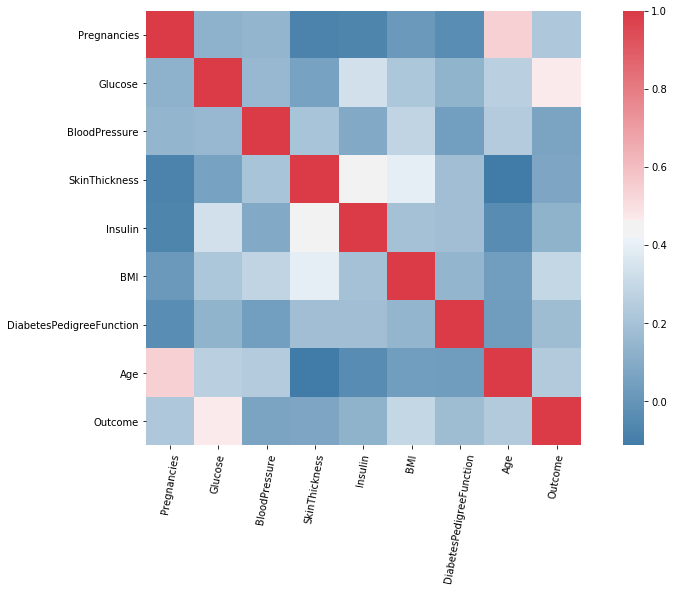

In [37]:
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, 
            cmap=sns.diverging_palette(240, 10, as_cmap=True),
            square=True)

plt.xticks(rotation=80);


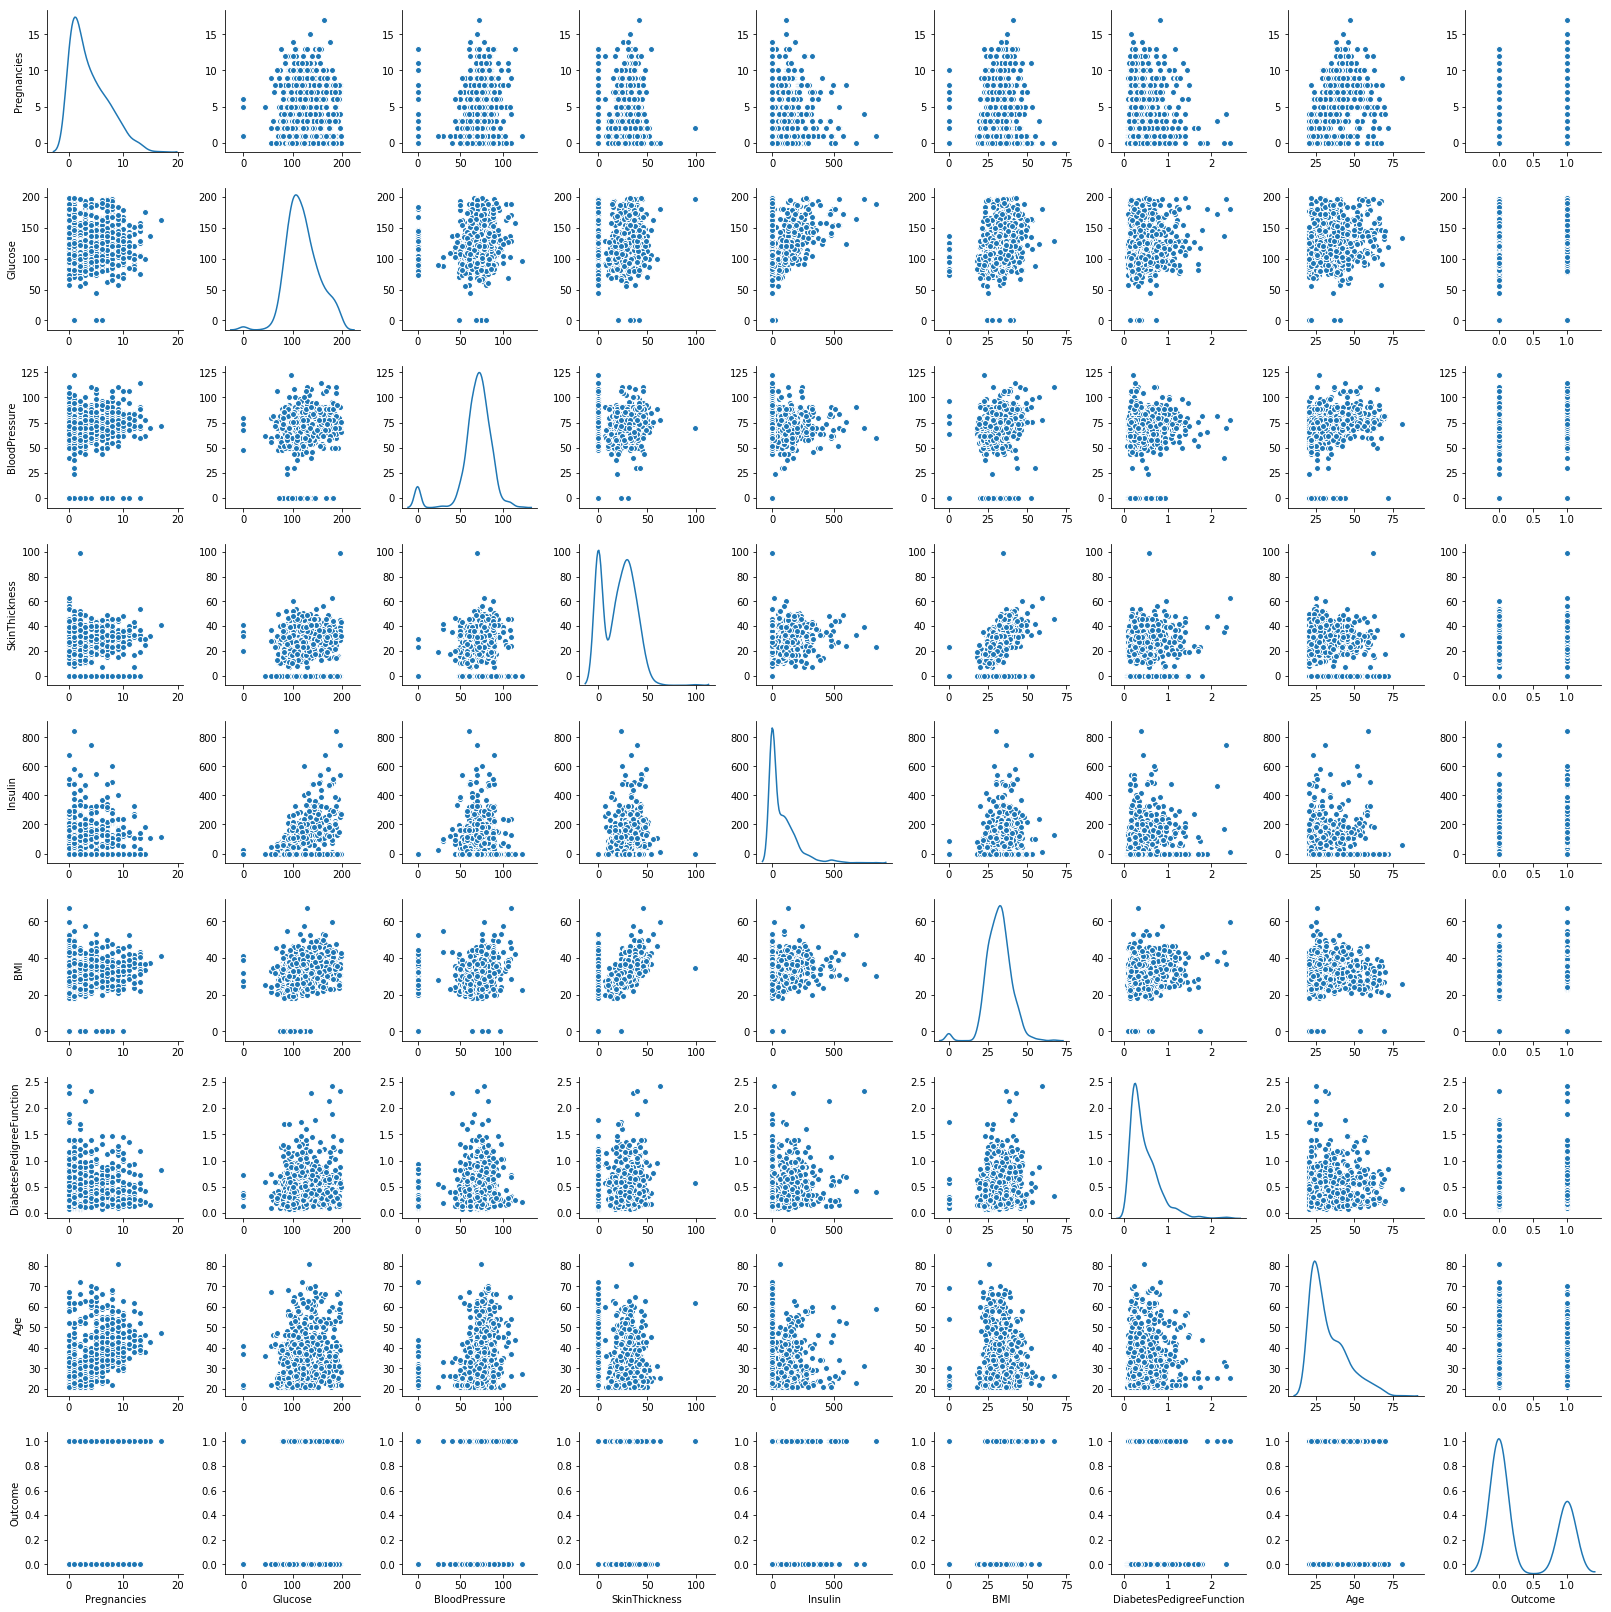

In [108]:
sns.pairplot(data=df,
             kind='scatter',
             palette='BrBG',
             diag_kind = 'kde')

# Evaluate algorithms

In [129]:
features = df.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=7)

## Performance of dummy model

In [134]:
df[target].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [137]:
print('Accuracy of dummy model: %.2f' % (500/df.shape[0]))

Accuracy of dummy model: 0.65


## Performance of models - spot check a bunch of algorithms

In [172]:
standardize = ('standardize', StandardScaler())

estimators = []
estimators.append(('LR', LogisticRegression()))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('NB', GaussianNB()))
estimators.append(('SVC', SVC()))
estimators.append(('RF', RandomForestClassifier(random_state=7)))

results = []
names = []

for estimator in estimators:
    names.append(estimator[0])
    
    pipe = Pipeline([standardize, estimator])
    kfold = KFold(n_splits=3, random_state=7)
    results.append(cross_val_score(pipe, X_train, y_train, cv=kfold))

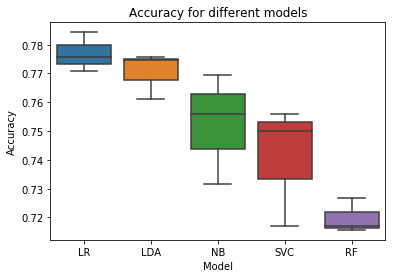

In [176]:
sns.boxplot(x=names, y=results)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for different models');

## Grid search optimization of RandomForest

In [191]:
model = RandomForestClassifier(class_weight='balanced', random_state=7)
param_grid = {
    'min_samples_split': [2, 4, 6, 7], 
    'n_estimators' : [10, 50, 100, 150],
    'max_depth': [2, 3, 4, 5, 6],
    'max_features': [1, 2, 3, 4, 5],
}

grid_search = GridSearchCV(model, 
                           param_grid, 
                           scoring='accuracy', 
                           cv=kfold,
                           n_jobs=-1)

grid_result = grid_search.fit(X_train, y_train)

In [192]:
print("Best accuracy: %.2f using %s" % (grid_result.best_score_, grid_result.best_params_))
model = grid_result.best_estimator_

Best accuracy: 0.77 using {'max_depth': 4, 'max_features': 3, 'min_samples_split': 4, 'n_estimators': 100}


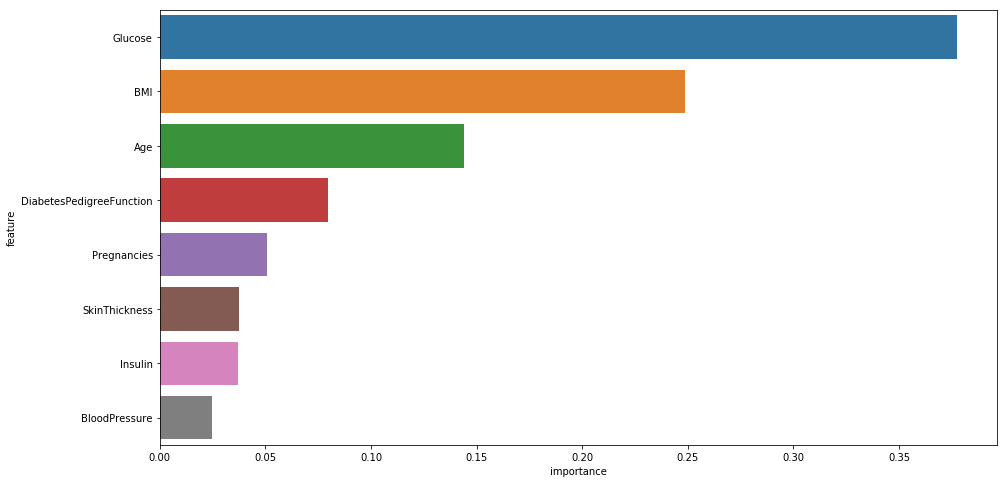

In [195]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(15, 8))
sns.barplot(x=feature_importance['importance'][:20], y=feature_importance['feature'][:20]);

In [194]:
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set: %.2f' % test_accuracy)

Accuracy on test set: 0.79
